# Amazone Fine Food Review Analysis Naive Bayes

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

   Number of reviews: 568,454<br>
   Number of users: 256,059<br>
   Number of products: 74,258<br>
   Timespan: Oct 1999 - Oct 2012<br>
   Number of Attributes/Columns in data: 10 

Attribute Information:

   1. Id
   2. ProductId - unique identifier for the product
   3. UserId - unqiue identifier for the user
   4. ProfileName
   5. HelpfulnessNumerator - number of users who found the review helpful
   6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
   7. Score - rating between 1 and 5
   8. Time - timestamp for the review
   9. Summary - brief summary of the review
   10. Text - text of the review



### Objective:

    Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


In [1]:
import re
import nltk
import string
import pickle
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from nltk.corpus import stopwords
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

## Loading data

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


#parti
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Data Cleaning

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

## Observation:-
     It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## Text Preprocessing: Stemming, stop-word removal and Lemmatization

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews


In [9]:
# find sentences containing HTML tags

i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

10
I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!


In [10]:


stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [12]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [13]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

## Sorting data 

In [14]:
final.sort_values("Time",ascending=True, inplace=True, kind='quicksort')

#### Replace Negative with 0 and Positive with 1

In [15]:
final['Score'].replace(['negative', 'positive'],[0,1],inplace=True)

In [16]:
final.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,364171.000000,364171.000000,364171.000000,364171.000000,3.641710e+05
mean,261814.561014,1.739021,2.186841,0.843178,1.296135e+09
std,166958.768333,6.723921,7.348482,0.363633,4.864772e+07
min,1.000000,0.000000,0.000000,0.000000,9.393408e+08
25%,113379.500000,0.000000,0.000000,1.000000,1.270858e+09
50%,249445.000000,0.000000,1.000000,1.000000,1.311379e+09
75%,407408.500000,2.000000,2.000000,1.000000,1.332893e+09
max,568454.000000,866.000000,878.000000,1.000000,1.351210e+09


## Function 

##### codes for-
* feature importance
* apply naive bayes on amazon fine food reviews dataset
* find best alpha using cross validation
* find confusion_matrix, accuracy, recall, f1 score, precision



In [4]:
# defining naive bayes function that does cross validation , plotting error vs alpha, accuracy, test accuracy 
# and confusion matrix
# this function takes 'algo', 'X_train', 'X_test', 'y_train', 'y_test' as arguments
def naive(algo,X_train, X_test, y_train, y_test):
    
    #Normalize Data
    X_train = preprocessing.normalize(X_train)
    print("Train Data Size: ",X_train.shape)

    #Normalize Data
    X_test = preprocessing.normalize(X_test)
    print("Test Data Size: ",X_test.shape)
    
    
    if(algo=='MNB'):
         clf=MultinomialNB
    elif(algo=='BNB'):
         clf=BernoulliNB
    
    #Finding the best 'alpha' using Cross Validation
    
    naive_bayes = clf()
    param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
    tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
    gsv = GridSearchCV(naive_bayes,param_grid,cv=tscv,verbose=1,n_jobs = -1)
    gsv.fit(X_train,y_train)

    print("Best HyperParameter: ",gsv.best_params_)
    print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
    
    #Ploting Accuracy and Alpha
    
    x=[]
    y=[]
    for a in gsv.grid_scores_:
        x.append(a[0]['alpha']) 
        y.append(a[1])
    plt.xlim(-10,1000)
    plt.ylim(0.8,0.9)
    plt.xlabel(r"$\alpha$",fontsize=15)
    plt.ylabel("accuracy")
    plt.title(r'Accuracy v/s $\alpha$')
    plt.plot(x,y)
    plt.show()
    
    #Testing Accuracy on Test data
    
    naive_bayes = clf(alpha=0.001)
    naive_bayes.fit(X_train,y_train)
    y_pred = naive_bayes.predict(X_test)
    print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
    print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
    print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
    print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
    print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
    
    confusion = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(confusion, annot=True,annot_kws={"size": 16}, fmt='g')

## 1.Bag Of Word 

   The bag-of-words model is a simplifying representation used in natural language processing and information retrieval(IR).Also known as the vector space model.The bag-of-words model is commonly used in methods of document classification where the occurrence of each word is used as a feature for training a classifier.OR
   Simply,Converting a collection of text documents to a matrix of token counts

## Uni-Gram Bernoulli Naive Bayes

In [18]:
X = final["CleanedText"]
y = final["Score"]

Train Data Size:  (254919, 59190)
Test Data Size:  (109252, 59190)
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   34.6s finished


Best HyperParameter:  {'alpha': 0.01}
Best Accuracy: 88.63%


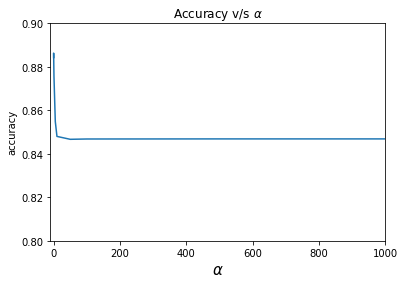

Accuracy on test set: 88.283%
Precision on test set: 0.924
Recall on test set: 0.934
F1-Score on test set: 0.929
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



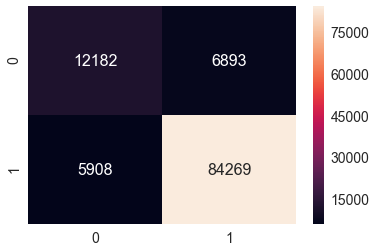

In [19]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,shuffle=False,random_state=0)

#Bag of Words
count = CountVectorizer() 
X_train = count.fit_transform(X_train)

X_test = count.transform(X_test)

naive(algo="BNB",X_train = X_train, X_test=X_test, y_train=y_train, y_test=y_test)

## 2 Uni-gram Multinomial Naive Bayes 


Train Data Size:  (254919, 59190)
Test Data Size:  (109252, 59190)
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   31.2s finished


Best HyperParameter:  {'alpha': 0.005}
Best Accuracy: 87.21%


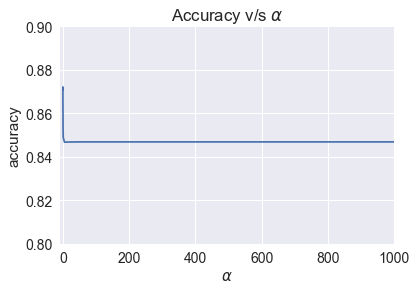

Accuracy on test set: 85.989%
Precision on test set: 0.858
Recall on test set: 0.996
F1-Score on test set: 0.921
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



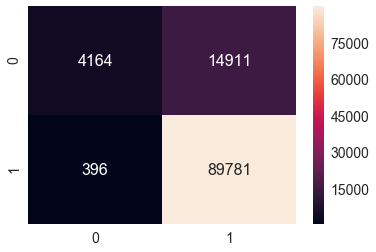

In [20]:

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,shuffle=False,random_state=0)

#Bag of Words
count = CountVectorizer(binary=True) 
X_train = count.fit_transform(X_train)

X_test = count.transform(X_test)

naive(algo="MNB",X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

## 3. Bi-Gram Bernoulli Naive Bayes

Train Data Size:  (254919, 2307617)
Test Data Size:  (109252, 2307617)
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.7min finished


Best HyperParameter:  {'alpha': 0.001}
Best Accuracy: 89.18%


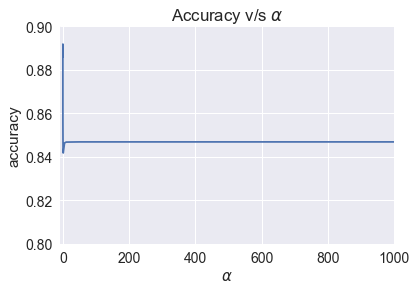

Accuracy on test set: 88.386%
Precision on test set: 0.885
Recall on test set: 0.987
F1-Score on test set: 0.933
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



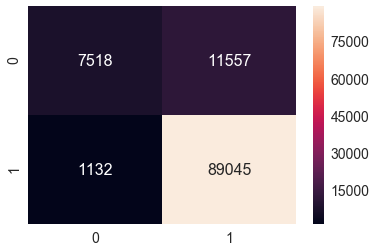

In [21]:

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,shuffle=False,random_state=0)

#taking one words and two consecutive words together
bi_gram = CountVectorizer(ngram_range=(1,2),)

X_train = bi_gram.fit_transform(X_train)

X_test = bi_gram.transform(X_test)

naive(algo="BNB",X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

## 4. Bi-Gram Multinomial Naive Bayes

Train Data Size:  (254919, 2307617)
Test Data Size:  (109252, 2307617)
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.1min finished


Best HyperParameter:  {'alpha': 0.005}
Best Accuracy: 90.00%


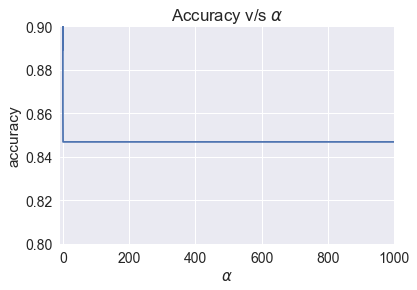

Accuracy on test set: 88.430%
Precision on test set: 0.881
Recall on test set: 0.993
F1-Score on test set: 0.934
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



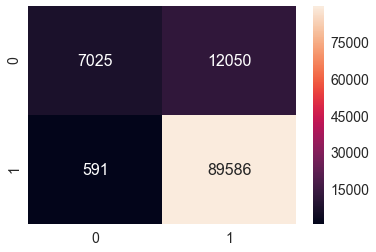

In [22]:

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,shuffle=False,random_state=0)

#taking one words and two consecutive words together
bi_gram = CountVectorizer(ngram_range=(1,2),binary=True)

X_train = bi_gram.fit_transform(X_train)

X_test = bi_gram.transform(X_test)

naive(algo="MNB",X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

## 5.TFIDF Bernoulli Naive Bayes

Train Data Size:  (254919, 2307617)
Test Data Size:  (109252, 2307617)
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.5min finished


Best HyperParameter:  {'alpha': 0.001}
Best Accuracy: 89.18%


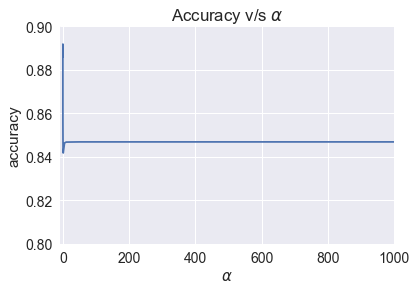

Accuracy on test set: 88.386%
Precision on test set: 0.885
Recall on test set: 0.987
F1-Score on test set: 0.933
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



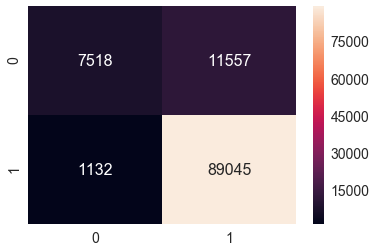

In [23]:

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,shuffle=False,random_state=0)


tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams

X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

naive(algo="BNB",X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

## 6.TFIDF Multinomial Naive Bayes 

Train Data Size:  (254919, 2307617)
Test Data Size:  (109252, 2307617)
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.0min finished


Best HyperParameter:  {'alpha': 0.01}
Best Accuracy: 88.44%


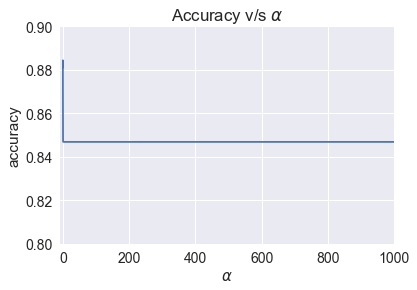

Accuracy on test set: 87.605%
Precision on test set: 0.875
Recall on test set: 0.991
F1-Score on test set: 0.930
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



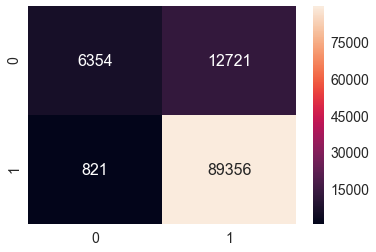

In [24]:

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,shuffle=False,random_state=0)


tfidf = TfidfVectorizer(ngram_range=(1,2),binary=True) #Using bi-grams

X_train = tfidf.fit_transform(X_train)

X_test = tfidf.transform(X_test)

naive(algo="MNB",X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

## 7.Feature importance using the best alpha for Bag of words representation

In [25]:
X_train = final["CleanedText"]
y_train = final["Score"]

In [26]:
#Bag of word featurization
count=CountVectorizer(binary=True)
X_train=count.fit_transform(X_train.values)

In [27]:
clf=MultinomialNB(alpha=11)
clf.fit(X_train,y_train)

MultinomialNB(alpha=11, class_prior=None, fit_prior=True)

#### 7.1 finding the top 100 negative class words

In [28]:
neg_f_imp=clf.feature_log_prob_[0].argsort()[-100:]
neg = [ ]
for i in range(100):
    neg.append(np.take(count.get_feature_names(),neg_f_imp[i]))

word = ' '.join(neg)

print(word)

mani wast lot read work expect actual anoth old compani sweet contain stuff chocol doesnt mix seem see sure dog sugar year sinc cant found day tea recommend away item pack smell howev ingredi open drink back differ water still thing store brand receiv ive two find littl money someth never got great well way price give made thought didnt say know could bag also coffe think bad better want packag first purchas review food box bought eat disappoint amazon love look realli time much make order even dont use get buy good flavor tri would one product like tast


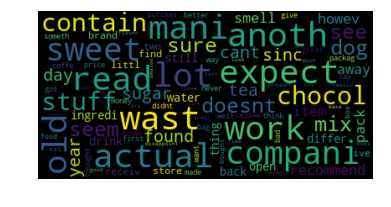

In [29]:
wordcloud = WordCloud(max_font_size=40).generate(word)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### 7.2 finding the top 100 positive class words 

In [30]:
pos_f_imp=clf.feature_log_prob_[1].argsort()[-100:]
pos = [ ]
for i in range(100):
    pos.append(np.take(count.get_feature_names(),pos_f_imp[i]))
word = " ".join(pos)
print(word)

ship free review ever got right never local snack wonder easi take fresh treat chocol dog pack without alway everi still could cant water mani two cup know differ come lot say add thing keep bit packag sugar sinc box perfect bought made brand think purchas need way work nice favorit enjoy mix look want give sweet first delici bag drink high found year tea day better recommend ive even coffe food store well order littl dont eat also much price find amazon best realli would time buy get make product tri use one flavor great good love tast like


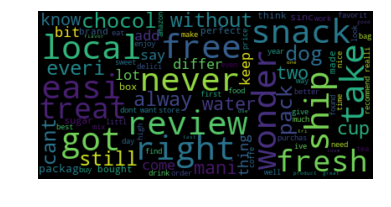

In [31]:
wordcloud = WordCloud(max_font_size=40).generate(word)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 8.Feature importance using the best alpha for Tfidf representation

In [32]:
X_train = final["CleanedText"]
y_train = final["Score"]

In [33]:
tfidf_vect=TfidfVectorizer(ngram_range=(1,1), binary=True)
x_train=tfidf_vect.fit_transform(X_train.values)

In [34]:
clf=MultinomialNB(alpha=11)
clf.fit(x_train,y_train)

MultinomialNB(alpha=11, class_prior=None, fit_prior=True)

#### finding the top 100 negative class words 

In [36]:
neg_f_imp=clf.feature_log_prob_[0].argsort()[-100:]
neg = [ ]
for i in range(100):
    neg.append(np.take(tfidf_vect.get_feature_names(),neg_f_imp[i]))
word = " ".join(neg)
print(word)

go great see ever terribl horribl seem ship contain stuff recommend sugar hard mayb read compani find doesnt sure noth old cant dog littl ive hope drink ingredi chocol wont well tea still thing differ store water expect back pack howev brand also two open give smell away someth made return love price way item never wast say know got first food better make could want think bag receiv amazon eat didnt time thought coffe packag realli review money much look purchas box bought bad use even get good order dont flavor tri disappoint one buy would product like tast


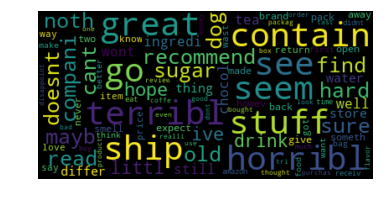

In [37]:
wordcloud = WordCloud(max_font_size=40).generate(word)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### 7.2 finding the top 100 positive class words 

In [38]:
pos_f_imp=clf.feature_log_prob_[1].argsort()[-100:]
pos = [ ]
for i in range(100):
    pos.append(np.take(tfidf_vect.get_feature_names(),pos_f_imp[i]))
word = " ".join(pos)
print(word)

still stuff definit know could healthi quick tasti right excel free say thing without come pack mani differ ship local everi ever sinc bit think made alway lot add fresh cup chocol wonder box treat packag cant keep easi sugar first way dog need brand snack look want bought work give mix purchas perfect bag nice sweet found day drink enjoy high year favorit even ive food better delici dont well recommend also littl tea eat much store would order amazon realli find coffe time price buy best get make tri one use product flavor like tast good great love


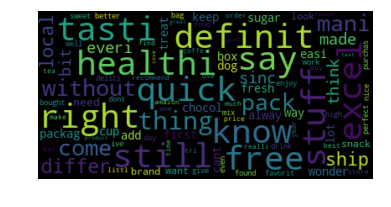

In [39]:
wordcloud = WordCloud(max_font_size=40).generate(word)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Performance Table

![title](nb.jpg)

# Conclusion -
1. We assumed that if 'Score' value is greater than 3 then it is a positive review otherwise it is a negative review. We have completly droppent the review which having 'Score' value 3.

2. we analyzed the textual imformation present in data. We have three types of featurization onto which we applied Naive bayes algorithm to analyze, they are- Bi-gram Bag of words representation uni-gram Binary representation and Tf-Idf representation of text. We can't apply naive bayes onto Avg word2vec and Tfidf avg word2vec because naive bayes works on a assumption that features should be independent to each other but word2vec are very dependent on the features.

3. we applied both MultinomialNB and BernoulliNB onto the Bag of words representation and Tfidf representation, and used scoring matrix like 'accuracy' , 'average_precision' , 'f1_micro' and 'recall'.

4. The best thing about Naive Bayes it much quicker than algorithms amazingly fast training times

5. Best Models are Bi-Gram with accuracy of 89.27% ,precision of 0.891 ,Recall of 0.992 and F1-Score of 0.938

6. Multinomial Naive Bayes does not work with negative values